In [12]:
# ==========================================
# XGBoost 주간학습 다음날 예측 (100 에포크, 조용한 출력, 호환성 개선)
# - train_data.csv, test_data.csv 사용
# - 타깃: "합산발전량(MWh)" (회귀)
# - 출력: 예측 CSV, 모델 파이프라인(pkl), 메타 JSON
# ==========================================
import os
import json
import warnings
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib

# -------------------------------------------------
# 전역: 불필요한 경고/로그 억제
# -------------------------------------------------
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

# ---------------------------
# 0. 사용자 설정
# ---------------------------
TRAIN_PATH = r"C:\ESG_Project1\file\merge_data\train_data.csv"
TEST_PATH  = r"C:\ESG_Project1\file\merge_data\test_data.csv"
TARGET_COL = "합산발전량(MWh)"

# 예: ["발전구분", "지역", "지점번호"]  (없으면 빈 리스트 [])
GROUP_KEYS = ["발전구분", "지역", "지점번호"]

OUT_PREFIX = "xgb_week2day"
RANDOM_STATE = 42
EPOCHS = 100               # ← 100 에포크 학습
VAL_DAYS = 7               # ← 학습 데이터의 마지막 7일을 검증으로 사용
LEARNING_RATE = 0.05

# 래그/롤링 설정
LAG_MAX = 168              # 7일 * 24시간
ROLL_WINDOWS = [24, 72, 168]

# ---------------------------
# 1. 유틸
# ---------------------------
def read_csv_flex(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    try:
        return pd.read_csv(path, encoding="utf-8", low_memory=False)
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="cp949", low_memory=False)

def detect_datetime(df: pd.DataFrame):
    # 단일 datetime 열
    for c in ["일시", "datetime", "timestamp", "DATE_TIME", "date_time"]:
        if c in df.columns:
            dt = pd.to_datetime(df[c], errors="coerce")
            if dt.notna().any():
                df["__dt__"] = dt
                return "__dt__"
    # 일자 + 시간
    date_cands = ["일자", "date"]
    hour_cands = ["시간", "hour", "HOUR"]
    date_col = next((c for c in date_cands if c in df.columns), None)
    hour_col = next((c for c in hour_cands if c in df.columns), None)
    if date_col and hour_col:
        h = df[hour_col].astype(str).str.extract(r"(\d{1,2})")[0].astype(float).clip(0, 23)
        df["__dt__"] = pd.to_datetime(df[date_col], errors="coerce") + pd.to_timedelta(h, unit="h")
        return "__dt__"
    return None

def add_time_features(df: pd.DataFrame, dt_col: str):
    df["hour"] = df[dt_col].dt.hour
    df["dayofweek"] = df[dt_col].dt.dayofweek
    df["month"] = df[dt_col].dt.month
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
    # 주기형 인코딩
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24.0)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24.0)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12.0)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12.0)
    return df

def ensure_keys(df, keys):
    return [k for k in (keys or []) if k in df.columns]

def add_lags_and_rolls(df_all: pd.DataFrame, dt_col: str, keys, target: str):
    """경고 최소화를 위해 래그/롤링을 한 번에 concat."""
    keys = ensure_keys(df_all, keys)
    df_all = df_all.sort_values(keys + [dt_col] if keys else [dt_col]).copy()

    # 래그 전체 생성
    lag_blocks = []
    for lag in range(1, LAG_MAX + 1):
        series = (df_all.groupby(keys)[target].shift(lag) if keys
                  else df_all[target].shift(lag))
        lag_blocks.append(series.rename(f"lag_{lag}"))
    lag_df = pd.concat(lag_blocks, axis=1)

    # 롤링 평균/표준편차
    roll_mean_blocks, roll_std_blocks = [], []
    for w in ROLL_WINDOWS:
        rm = (df_all.groupby(keys)[target].shift(1).rolling(w, min_periods=int(w*0.6)).mean()
              if keys else df_all[target].shift(1).rolling(w).mean())
        rs = (df_all.groupby(keys)[target].shift(1).rolling(w, min_periods=int(w*0.6)).std()
              if keys else df_all[target].shift(1).rolling(w).std())
        roll_mean_blocks.append(rm.rename(f"roll_mean_{w}"))
        roll_std_blocks.append(rs.rename(f"roll_std_{w}"))
    roll_df = pd.concat(roll_mean_blocks + roll_std_blocks, axis=1)

    # 원본 + 파생 합치기
    df_all = pd.concat([df_all, lag_df, roll_df], axis=1)
    return df_all

def choose_tree_method():
    try:
        XGBRegressor(n_estimators=1, tree_method="gpu_hist", predictor="gpu_predictor").fit(
            np.array([[0, 0]]), np.array([0.0])
        )
        return "gpu_hist", "gpu_predictor"
    except Exception:
        return "hist", "auto"

# ---------------------------
# 2. 데이터 로드
# ---------------------------
train = read_csv_flex(TRAIN_PATH)
test  = read_csv_flex(TEST_PATH)

dt_col_train = detect_datetime(train)
dt_col_test  = detect_datetime(test)
if dt_col_train is None or dt_col_test is None:
    raise ValueError("datetime 컬럼을 찾을 수 없습니다. (일시 또는 일자+시간 필요)")

# 시간 파생
train = add_time_features(train, dt_col_train)
test  = add_time_features(test, dt_col_test)

# ---------------------------
# 3. 히스토리 결합 후 래그/롤링 생성
# ---------------------------
all_df = pd.concat([train, test], axis=0, ignore_index=True)
all_df = add_lags_and_rolls(all_df, "__dt__", GROUP_KEYS, TARGET_COL)

# 다시 분리
n_train = len(train)
train_df = all_df.iloc[:n_train].copy()
test_df  = all_df.iloc[n_train:].copy()

# 학습 입력/타깃
lag_cols = [f"lag_{i}" for i in range(1, LAG_MAX + 1)]
valid_mask = train_df[lag_cols].notna().all(axis=1)

X_train = train_df.loc[valid_mask].drop(columns=[TARGET_COL, "__dt__"], errors="ignore")
y_train = train_df.loc[valid_mask, TARGET_COL].astype(float)

X_test = test_df.drop(columns=[TARGET_COL, "__dt__"], errors="ignore")
y_test = test_df[TARGET_COL] if TARGET_COL in test_df.columns else None

# ---------------------------
# 4. 검증 분리 (학습 마지막 7일)
# ---------------------------
cutoff = train_df["__dt__"].max() - pd.Timedelta(days=VAL_DAYS)
val_mask = train_df.loc[valid_mask, "__dt__"] >= cutoff

X_tr, X_val = X_train.loc[~val_mask], X_train.loc[val_mask]
y_tr, y_val = y_train.loc[~val_mask], y_train.loc[val_mask]

# ---------------------------
# 5. 전처리/모델 구성 및 학습 (100 에포크, 조용)
# ---------------------------
tree_method, predictor = choose_tree_method()
model = XGBRegressor(
    n_estimators=EPOCHS,
    learning_rate=LEARNING_RATE,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    tree_method=tree_method,
    predictor=predictor,
    eval_metric="rmse",
    verbosity=0,          # 내부 로그 끔
)

# 전처리는 전체 학습셋 기준으로 fit → 데이터 일관성 보장
num_tf = Pipeline([("imputer", SimpleImputer(strategy="median"))])
cat_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
preprocess = ColumnTransformer(
    transformers=[
        ("num", num_tf, numeric_cols),
        ("cat", cat_tf, categorical_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3,
)

# 전처리 학습(전체 학습셋) 후 변환
preprocess.fit(X_train)
X_tr_prep  = preprocess.transform(X_tr)
X_val_prep = preprocess.transform(X_val)

# 모델 학습(조용하게 100라운드)
print(f"▶ 모델 학습 중... (라운드={EPOCHS}, 검증 구간={VAL_DAYS}일)")
model.fit(X_tr_prep, y_tr)

# 검증 점수(숫자 한 줄만)
val_pred = model.predict(X_val_prep)
val_mae  = mean_absolute_error(y_val, val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
val_r2   = r2_score(y_val, val_pred)
print(f"[Validation] MAE={val_mae:.4f} | RMSE={val_rmse:.4f} | R2={val_r2:.4f}")

# ---------------------------
# 6. 예측 및 파일 저장
# ---------------------------
X_test_prep = preprocess.transform(X_test)
test_pred = model.predict(X_test_prep)

out_dir = os.path.dirname(TEST_PATH)
os.makedirs(out_dir, exist_ok=True)

pred_df = test.copy()
pred_df["예측합산발전량(MWh)"] = test_pred
pred_path = os.path.join(out_dir, f"{OUT_PREFIX}_predictions.csv")
pred_df.to_csv(pred_path, index=False, encoding="utf-8-sig")
print(f"✅ 예측 결과 저장: {pred_path}")

# ---------------------------
# 7. 파이프라인/메타 저장
# ---------------------------
# 전처리(fitted) + 모델(fitted)을 파이프라인으로 묶어 저장
pipe = Pipeline([("preprocess", preprocess), ("model", model)])
model_path = os.path.join(out_dir, f"{OUT_PREFIX}_pipeline.pkl")
joblib.dump(pipe, model_path)
print(f"✅ 모델 파이프라인 저장: {model_path}")

# 테스트 성능(정답이 있을 때)
metrics = None
if y_test is not None and y_test.notna().any():
    y_true = y_test.astype(float).values
    mask_eval = np.isfinite(y_true)
    if mask_eval.any():
        mae = mean_absolute_error(y_true[mask_eval], test_pred[mask_eval])
        rmse = np.sqrt(mean_squared_error(y_true[mask_eval], test_pred[mask_eval]))
        r2 = r2_score(y_true[mask_eval], test_pred[mask_eval])
        metrics = {"MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)}
        print(f"[Test] MAE={mae:.4f} | RMSE={rmse:.4f} | R2={r2:.4f}")

meta = {
    "train_path": TRAIN_PATH,
    "test_path": TEST_PATH,
    "target": TARGET_COL,
    "datetime_col": "__dt__",
    "group_keys_used": ensure_keys(train, GROUP_KEYS),
    "tree_method": tree_method,
    "predictor": predictor,
    "lags": LAG_MAX,
    "roll_windows": ROLL_WINDOWS,
    "epochs": EPOCHS,
    "val_days": VAL_DAYS,
    "numeric_cols": numeric_cols,
    "categorical_cols": categorical_cols,
    "metrics_val": {"MAE": float(val_mae), "RMSE": float(val_rmse), "R2": float(val_r2)},
    "metrics_test": metrics,
}
with open(os.path.join(out_dir, f"{OUT_PREFIX}_meta.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print("ℹ️ 메타 저장 완료")


▶ 모델 학습 중... (라운드=100, 검증 구간=7일)
[Validation] MAE=20.6069 | RMSE=62.6544 | R2=0.9240
✅ 예측 결과 저장: C:\ESG_Project1\file\merge_data\xgb_week2day_predictions.csv
✅ 모델 파이프라인 저장: C:\ESG_Project1\file\merge_data\xgb_week2day_pipeline.pkl
[Test] MAE=1.2314 | RMSE=11.3137 | R2=0.8937
ℹ️ 메타 저장 완료


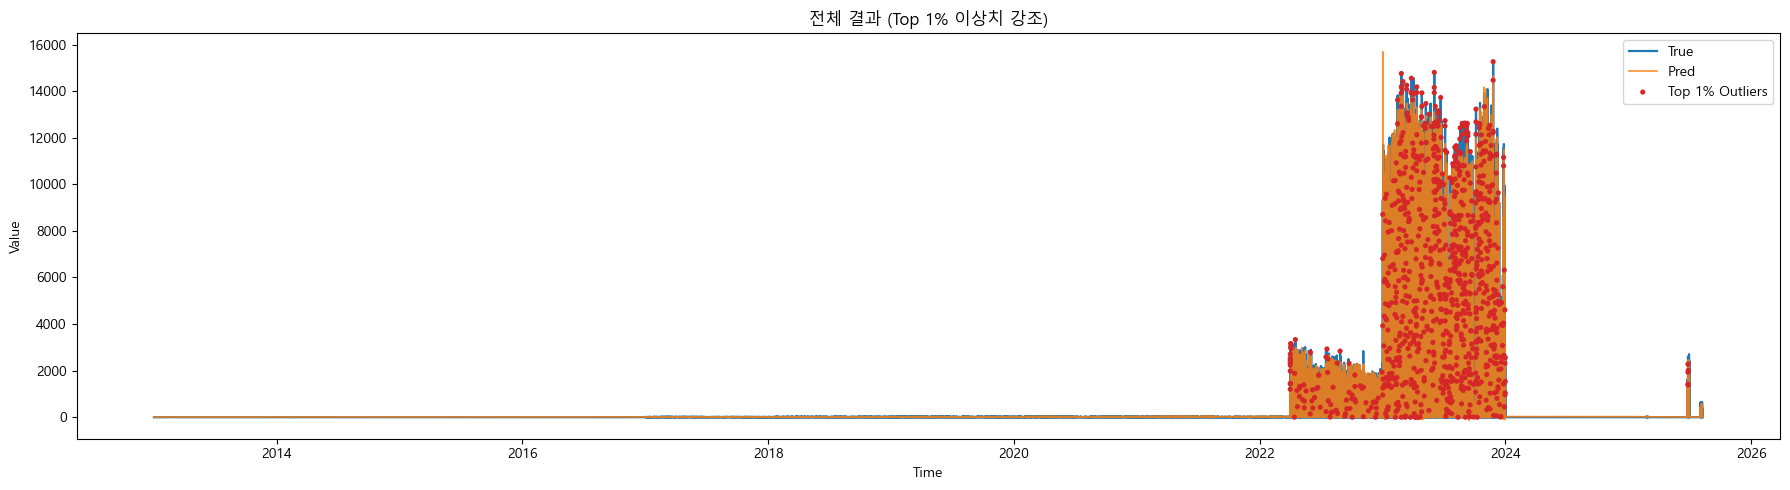

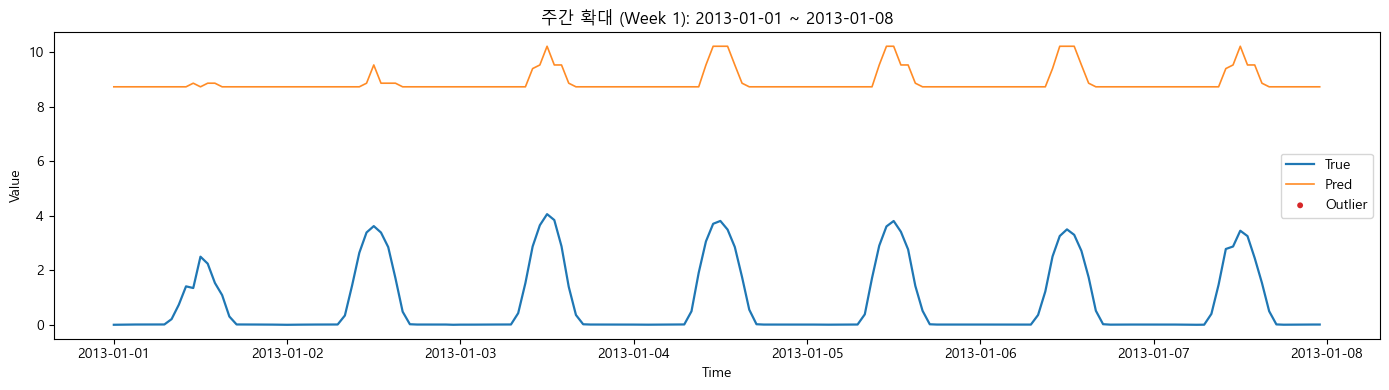

In [14]:
# ==========================================
# 이상치 시각화 (전체/주간 확대, Top p% 강조)
# - 메타/모델/데이터 재활용
# - 잔차 절대값(or anom_score) 상위 퍼센타일을 이상치로 표시
# - 색상 고정: True=파랑, Pred=주황, Outlier=빨강
# ==========================================
import os, json, warnings
import numpy as np
import pandas as pd
import matplotlib, matplotlib.pyplot as plt

# ---------- 사용자 설정 ----------
CSV_TO_EVAL = r"C:\ESG_Project1\file\merge_data\test_data.csv"
OUT_PREFIX  = "xgb_week2day"
MODEL_PATH  = os.path.join(os.path.dirname(CSV_TO_EVAL), f"{OUT_PREFIX}_pipeline.pkl")
META_PATH   = os.path.join(os.path.dirname(CSV_TO_EVAL), f"{OUT_PREFIX}_meta.json")

# 특정 그룹만 보고 싶으면 지정 (예: {"발전구분":"영동태양광"})
GROUP_FILTER = None

# 이상치 상위 비율 (예: 0.01 = Top 1%)
TOP_P = 0.01

# 주간 확대: 시작 날짜(포함) 지정, None이면 전체 첫 날
WEEK_START = None  # 예: "2025-01-08"

# ---------- 한글 폰트 ----------
def _set_korean_font():
    try:
        if os.name == "nt": matplotlib.rc("font", family="Malgun Gothic")
        elif hasattr(os, "uname") and os.uname().sysname == "Darwin":
            matplotlib.rc("font", family="AppleGothic")
        matplotlib.rcParams["axes.unicode_minus"] = False
    except Exception:
        pass
_set_korean_font()

# ---------- 유틸 ----------
def read_csv_flex(p):
    try:
        return pd.read_csv(p, encoding="utf-8", low_memory=False)
    except UnicodeDecodeError:
        return pd.read_csv(p, encoding="cp949", low_memory=False)

def detect_datetime(df: pd.DataFrame):
    for c in ["일시","datetime","timestamp","DATE_TIME","date_time","__dt__"]:
        if c in df.columns:
            dt = pd.to_datetime(df[c], errors="coerce")
            if dt.notna().any():
                df["__dt__"] = dt
                return "__dt__"
    dc = next((c for c in ["일자","date"] if c in df.columns), None)
    hc = next((c for c in ["시간","hour","HOUR"] if c in df.columns), None)
    if dc and hc:
        h = df[hc].astype(str).str.extract(r"(\d{1,2})")[0].astype(float).clip(0,23).fillna(0).astype(int)
        df["__dt__"] = pd.to_datetime(df[dc], errors="coerce") + pd.to_timedelta(h, unit="h")
        return "__dt__"
    return None

def add_time_features(df: pd.DataFrame, dt_col: str):
    df["hour"] = df[dt_col].dt.hour
    df["dayofweek"] = df[dt_col].dt.dayofweek
    df["month"] = df[dt_col].dt.month
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
    df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24.0)
    df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24.0)
    df["month_sin"] = np.sin(2*np.pi*df["month"]/12.0)
    df["month_cos"] = np.cos(2*np.pi*df["month"]/12.0)
    return df

def ensure_keys(df, keys): 
    return [k for k in (keys or []) if k in df.columns]

def add_lags_and_rolls(df_all: pd.DataFrame, dt_col: str, keys, target: str, lag_max: int, roll_windows):
    keys = ensure_keys(df_all, keys)
    df_all = df_all.sort_values(keys + [dt_col] if keys else [dt_col]).copy()
    g = df_all.groupby(keys) if keys else df_all.assign(_=1).groupby("_")
    for lag in range(1, lag_max+1):
        df_all[f"lag_{lag}"] = g[target].shift(lag)
    for w in roll_windows:
        df_all[f"roll_mean_{w}"] = g[target].shift(1).rolling(w, min_periods=int(w*0.6)).mean()
        df_all[f"roll_std_{w}"]  = g[target].shift(1).rolling(w, min_periods=int(w*0.6)).std()
    return df_all

# ---------- 로드 ----------
if not os.path.exists(META_PATH): raise FileNotFoundError(META_PATH)
if not os.path.exists(MODEL_PATH): raise FileNotFoundError(MODEL_PATH)
if not os.path.exists(CSV_TO_EVAL): raise FileNotFoundError(CSV_TO_EVAL)

with open(META_PATH, "r", encoding="utf-8") as f: 
    meta = json.load(f)
TARGET_COL   = meta.get("target", "합산발전량(MWh)")
GROUP_KEYS   = meta.get("group_keys_used", [])
LAG_MAX      = int(meta.get("lags", 168))
ROLL_WINDOWS = list(meta.get("roll_windows", [24,72,168]))
TRAIN_PATH   = meta.get("train_path")

eval_df = read_csv_flex(CSV_TO_EVAL)
dt_col = detect_datetime(eval_df)
if dt_col is None: 
    raise ValueError("datetime 컬럼을 찾을 수 없습니다.")
eval_df = add_time_features(eval_df, dt_col)
if GROUP_FILTER:
    for k, v in GROUP_FILTER.items():
        if k in eval_df.columns: 
            eval_df = eval_df[eval_df[k] == v]

# 학습 마지막 168시간을 이어 붙여 동일 피처 재현
if TRAIN_PATH and os.path.exists(TRAIN_PATH):
    tr = read_csv_flex(TRAIN_PATH)
    dt_tr = detect_datetime(tr)
    if dt_tr is None: 
        raise ValueError("train_data에서 datetime 생성 실패")
    tr = add_time_features(tr, dt_tr)
    keys = ensure_keys(eval_df, GROUP_KEYS)
    if keys:
        tail = tr.sort_values(keys + [dt_tr]).groupby(keys, as_index=False).tail(LAG_MAX)
    else:
        tail = tr.sort_values(dt_tr).tail(LAG_MAX)
    common = list(set(tail.columns) & set(eval_df.columns))
    base = pd.concat([tail[common], eval_df[common]], axis=0, ignore_index=True)
else:
    base = eval_df.copy()

base = add_lags_and_rolls(base, "__dt__", GROUP_KEYS, TARGET_COL, LAG_MAX, ROLL_WINDOWS)
eval_part = base.iloc[len(base) - len(eval_df):].copy()

# ---------- 예측 ----------
import joblib
pipe = joblib.load(MODEL_PATH)
X = eval_part.drop(columns=[c for c in [TARGET_COL, "__dt__"] if c in eval_part.columns], errors="ignore")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    y_pred = pipe.predict(X)

pred = eval_part[[dt_col] + [k for k in ensure_keys(eval_part, GROUP_KEYS)]].copy()
pred["y_pred"] = y_pred
if TARGET_COL in eval_part.columns:
    pred["y_true"] = eval_part[TARGET_COL].astype(float).values
else:
    raise ValueError("이상치 시각화는 실측 타깃 열이 필요합니다.")

# 여러 그룹이면 시간별 합계로 통합
agg = pred.groupby(dt_col, as_index=False).sum(numeric_only=True).sort_values(dt_col)
agg["resid"] = agg["y_true"] - agg["y_pred"]

# 점수: anom_score가 있으면 사용, 없으면 |잔차|
anom_col = "anom_score"
if anom_col in agg.columns and agg[anom_col].notna().any():
    score = agg[anom_col].values
else:
    score = np.abs(agg["resid"].values)

thr = np.quantile(score[~np.isnan(score)], 1.0 - TOP_P)
agg["is_outlier"] = score >= thr

# ---------- 색상 고정 ----------
COLOR_TRUE = "#1f77b4"   # 파랑
COLOR_PRED = "#ff7f0e"   # 주황
COLOR_OUTL = "#d62728"   # 빨강

# ---------- (A) 전체 플롯 ----------
plt.figure(figsize=(18,5))
plt.plot(agg[dt_col], agg["y_true"], label="True", linewidth=1.6, color=COLOR_TRUE)
plt.plot(agg[dt_col], agg["y_pred"], label="Pred", linewidth=1.2, color=COLOR_PRED, alpha=0.85)
out = agg[agg["is_outlier"]]
plt.scatter(out[dt_col], out["y_true"], s=14, label=f"Top {int(TOP_P*100)}% Outliers",
            zorder=5, color=COLOR_OUTL, edgecolors="none")
plt.title(f"전체 결과 (Top {int(TOP_P*100)}% 이상치 강조)")
plt.xlabel("Time"); plt.ylabel("Value"); plt.legend()
plt.tight_layout(); plt.show()

# ---------- (B) 주간 확대 플롯 ----------
if WEEK_START is None:
    start = agg[dt_col].min().normalize()
else:
    start = pd.to_datetime(WEEK_START).normalize()
end = start + pd.Timedelta(days=7)

week = agg[(agg[dt_col] >= start) & (agg[dt_col] < end)]
plt.figure(figsize=(14,4))
plt.plot(week[dt_col], week["y_true"], label="True", linewidth=1.6, color=COLOR_TRUE)
plt.plot(week[dt_col], week["y_pred"], label="Pred", linewidth=1.2, color=COLOR_PRED, alpha=0.9)
wk_out = week[week["is_outlier"]]
plt.scatter(wk_out[dt_col], wk_out["y_true"], s=18, label="Outlier", zorder=6,
            color=COLOR_OUTL, edgecolors="none")
plt.title(f"주간 확대 (Week 1): {start.date()} ~ {end.date()}")
plt.xlabel("Time"); plt.ylabel("Value"); plt.legend()
plt.tight_layout(); plt.show()

